In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sns.plotting_context(context='paper')
sns.set_palette('rainbow')

import pandas as pd

In [2]:
sales = pd.read_csv('../../../data/mckinsey/sales.csv', index_col='ID')

skus = pd.read_csv('../../../data/mckinsey/sku.csv', index_col='SKU')

sales = sales.join(skus, on='SKU')

#### Clean dataset

In [3]:
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.loc[sales['date'] > '2020-04-01']
sales['sales'] = sales['sales'].fillna(1)

In [4]:
timeframe_of_interest = pd.date_range(start=sales['date'].min(), end=sales['date'].max())

In [28]:
sales_time_series = sales.groupby('date')['sales'].sum().reindex(timeframe_of_interest, fill_value=0).reset_index()
sales_time_series.rename(columns={'index': 'ds', 'sales': 'y'}, inplace=True)

training_set = sales_time_series.iloc[:-120]
validation_set = sales_time_series.iloc[-120:]

<AxesSubplot:xlabel='ds'>

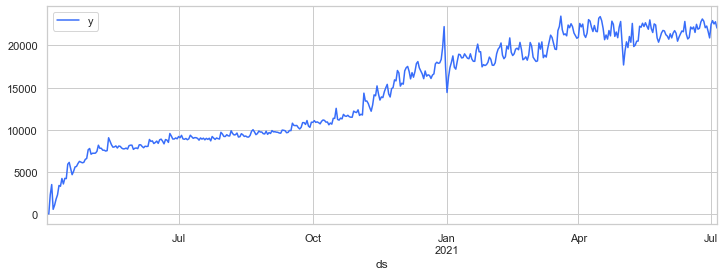

In [29]:
sales_time_series.plot(x='ds', y='y', figsize=(12, 4))

#### NeuralProphet

In [30]:
import neuralprophet

In [31]:
m = neuralprophet.NeuralProphet()
m.add_country_holidays(country_name='US', lower_window=-4, upper_window=2)

In [32]:
m.fit(training_set)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  a

  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-01, min: 1.90E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-01, min: 2.27E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.17E-01
Epoch[287/287]: 100%|██████████| 287/287 [00:11<00:00, 24.28it/s, SmoothL1Loss=0.000273, MAE=314, RMSE=444, RegLoss=0]       


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.652548,20686.654527,25487.112109,0.0
1,0.613579,19861.086305,24469.274288,0.0
2,0.573498,19012.282767,23338.141176,0.0
3,0.527926,18049.294014,22050.778585,0.0
4,0.479388,16997.637006,20810.804848,0.0
...,...,...,...,...
282,0.000274,314.586785,444.110005,0.0
283,0.000274,314.226433,444.696199,0.0
284,0.000274,314.129057,437.502623,0.0
285,0.000273,313.977956,440.461327,0.0


In [33]:
training_set_forecast = m.predict(training_set)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  additive_events[key] = offset_feature

WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: Perf

In [34]:
future = m.make_future_dataframe(training_set, periods=200, n_historic_predictions=200)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\

<AxesSubplot:xlabel='ds'>

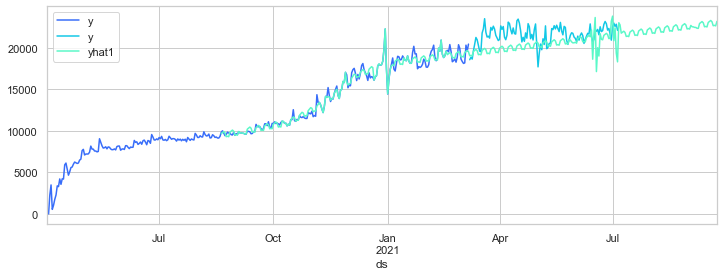

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))

training_set.plot(x='ds', y='y', ax=ax)
validation_set.plot(x='ds', y='y', ax=ax)
forecast.plot(x='ds', y='yhat1', ax=ax)